# RL Portfolio Optimization — Robust Subset Testing (Unequal Weights)

This notebook tests the RL-optimized portfolio against **unequal-weight baseline** using **robust inference techniques**.

**Robust Inference Techniques Applied:**
1. **Start-step ensemble**: Run policy from multiple start indices, aggregate weights
2. **Last-K smoothed weights**: Use median of last K steps' smoothed weights
3. **Cap + Floor**: Limit max/min per-asset allocation to reduce concentration
4. **Softmax temperature**: Flatten extreme allocations

**Evaluation Improvements:**
- `n_paths=2000` for reliable tail metrics
- `noise="block_bootstrap"` to preserve temporal dependence

**Baseline:** Market-cap-inspired unequal weights (not equal-weight)

**Metrics compared:**
- Mean Return
- Sharpe Ratio
- VaR (95%)
- CVaR (95%)

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Project imports
from input_parser import CapitalConfig
from scripts.compare_portfolio_mc import (
    run_portfolio_comparison,
    PortfolioComparison,
)
from stable_baselines3 import PPO
from portfolio_env import PortfolioEnv

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✓ Imports successful


## 2. Load Training Data and Model

In [2]:
# Load the TRAINING price data (same data the model was trained on)
RL_PRICE_CSV = project_root / 'data' / 'rl_training_price_data_india.csv'
price_df_full = pd.read_csv(RL_PRICE_CSV, index_col=0, parse_dates=True)

# All available tickers from training data
ALL_TICKERS = list(price_df_full.columns)
print(f"Total tickers in training data: {len(ALL_TICKERS)}")
print(f"Tickers: {ALL_TICKERS}")
print(f"Date range: {price_df_full.index[0]} to {price_df_full.index[-1]}")
print(f"Total rows: {len(price_df_full)}")

Total tickers in training data: 25
Tickers: ['HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'RELIANCE.NS', 'LT.NS', 'ONGC.NS', 'NTPC.NS', 'HINDUNILVR.NS', 'ITC.NS', 'NESTLEIND.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'M&M.NS', 'SUNPHARMA.NS', 'DRREDDY.NS', 'CIPLA.NS', 'BHARTIARTL.NS']
Date range: 2018-01-01 00:00:00 to 2021-10-29 00:00:00
Total rows: 1000


In [3]:
# Load the trained RL model
MODEL_PATH = None
candidates = []
models_dir = project_root / 'models'
archive_dir = project_root / 'logs' / 'archive'

if models_dir.exists():
    candidates += sorted(models_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
if archive_dir.exists():
    candidates += sorted(archive_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)

candidates = [p for p in candidates if 'ppo' in p.name.lower() or 'model' in p.name.lower()]

if candidates:
    MODEL_PATH = candidates[0]
    print(f"Loading model: {MODEL_PATH}")
    model = PPO.load(MODEL_PATH)
    print(f"✓ Model loaded successfully")
else:
    raise FileNotFoundError("No model found in 'models/' or 'logs/archive/'")

Loading model: c:\Users\Atharva Srivastava\Downloads\anndl\models\ppo_model.zip
✓ Model loaded successfully


## 3. Define Robust Inference Parameters

**Parameter Choices and Rationale:**

| Parameter | Value | Rationale |
|-----------|-------|------------|
| `start_offsets` | [-4,-3,-2,-1,0] | 5 runs from different market contexts; captures policy variation without needing multiple seeds |
| `ensemble_agg` | median | Median is robust to outliers; one bad start won't skew the ensemble |
| `last_k` | 5 | 5 steps (~1 week) smooths out daily noise while preserving recent market adaptation |
| `cap` | 0.15 (15%) | Conservative cap prevents single-asset concentration that kills CVaR; lower than 30% based on equal-weight results |
| `floor` | 0.02 (2%) | Ensures minimum diversification; all assets get at least 2% |
| `temperature` | 2.0 | Flattens extreme allocations; T=2 is moderate smoothing without fully equalizing |
| `n_paths` | 2000 | Standard for reliable tail metrics (VaR/CVaR need 1000+ for stability) |
| `noise` | block_bootstrap | Preserves temporal dependence in returns; more realistic than i.i.d. assumptions |

In [4]:
# =============================================================================
# ROBUST INFERENCE CONFIGURATION
# =============================================================================
# Using conservative config that showed good improvement on tail metrics

ROBUST_CONFIG = {
    # Start-step ensemble: run from multiple start offsets and aggregate
    # WHY: Gives varied market context to same policy without extra RNG seeds
    "use_start_ensemble": True,
    "start_offsets": [-4, -3, -2, -1, 0],  # 5 different starting points
    "ensemble_agg": "median",  # Median is robust to outlier runs
    
    # Last-K smoothed weights: use median of last K steps' weights
    # WHY: Preserves low-frequency policy signal, removes final-step noise
    "use_last_k_smoothing": True,
    "last_k": 5,  # ~1 trading week of smoothing
    
    # Cap and floor: limit per-asset allocation
    # WHY: Prevents concentration risk that hurts CVaR; 15% cap shown to improve tail metrics
    "use_cap_floor": True,
    "cap": 0.15,   # Max 15% per asset (conservative)
    "floor": 0.02, # Min 2% per asset (ensures diversification)
    
    # Softmax temperature: flatten extreme allocations
    # WHY: Reduces overconfidence in concentrated bets; T=2 is moderate smoothing
    "use_softmax_temp": True,
    "temperature": 2.0,
    
    # Monte Carlo evaluation parameters
    # WHY: 2000 paths for reliable VaR/CVaR; block_bootstrap preserves autocorrelation
    "n_paths": 2000,
    "noise": "block_bootstrap",
    "n_steps": 252,
}

print("Robust Inference Configuration:")
print("=" * 50)
for key, value in ROBUST_CONFIG.items():
    print(f"  {key}: {value}")
print("\n✓ Config optimized for tail-risk metrics (VaR/CVaR)")

Robust Inference Configuration:
  use_start_ensemble: True
  start_offsets: [-4, -3, -2, -1, 0]
  ensemble_agg: median
  use_last_k_smoothing: True
  last_k: 5
  use_cap_floor: True
  cap: 0.15
  floor: 0.02
  use_softmax_temp: True
  temperature: 2.0
  n_paths: 2000
  noise: block_bootstrap
  n_steps: 252

✓ Config optimized for tail-risk metrics (VaR/CVaR)


## 4. Define Unequal Weights for Each Ticker

Market-cap-inspired weights as baseline (same as original unequal notebook).

In [5]:
# =============================================================================
# DEFINE UNEQUAL WEIGHTS FOR EACH TICKER
# =============================================================================
# Based on approximate market-cap tiers (as of training period)

TICKER_RAW_WEIGHTS = {
    # Tier 1: Large-cap leaders (weight ~1.5)
    "RELIANCE.NS": 1.8,
    "TCS.NS": 1.6,
    "HDFCBANK.NS": 1.5,
    "INFY.NS": 1.4,
    "ICICIBANK.NS": 1.3,
    
    # Tier 2: Mid-large cap (weight ~1.0)
    "HINDUNILVR.NS": 1.1,
    "SBIN.NS": 1.0,
    "BHARTIARTL.NS": 1.0,
    "KOTAKBANK.NS": 1.0,
    "ITC.NS": 0.95,
    "LT.NS": 0.95,
    "AXISBANK.NS": 0.9,
    
    # Tier 3: Mid cap (weight ~0.7-0.8)
    "HCLTECH.NS": 0.85,
    "SUNPHARMA.NS": 0.8,
    "MARUTI.NS": 0.8,
    "WIPRO.NS": 0.75,
    "NTPC.NS": 0.7,
    "ONGC.NS": 0.7,
    "ASIANPAINT.NS": 0.7,
    "TATAMOTORS.NS": 0.7,
    
    # Tier 4: Smaller cap (weight ~0.5-0.6)
    "TECHM.NS": 0.65,
    "M&M.NS": 0.6,
    "DRREDDY.NS": 0.6,
    "CIPLA.NS": 0.55,
    "NESTLEIND.NS": 0.5,
}

def get_unequal_weights(tickers: list) -> dict:
    """Get normalized unequal weights for a subset of tickers."""
    raw = {t: TICKER_RAW_WEIGHTS.get(t, 0.5) for t in tickers}
    total = sum(raw.values())
    return {t: w / total for t, w in raw.items()}

# Show example
print("Example unequal weights for Banks subset:")
banks = ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS", "AXISBANK.NS", "KOTAKBANK.NS"]
bank_weights = get_unequal_weights(banks)
for t, w in bank_weights.items():
    print(f"  {t}: {w:.2%}")
print(f"  Sum: {sum(bank_weights.values()):.2%}")

Example unequal weights for Banks subset:
  HDFCBANK.NS: 26.32%
  ICICIBANK.NS: 22.81%
  SBIN.NS: 17.54%
  AXISBANK.NS: 15.79%
  KOTAKBANK.NS: 17.54%
  Sum: 100.00%


## 5. Define Ticker Subsets to Test

In [6]:
# =============================================================================
# DEFINE TICKER SUBSETS TO TEST
# =============================================================================

TICKER_SUBSETS = {
    # Banking sector
    "Banks": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS", "AXISBANK.NS", "KOTAKBANK.NS"],
    
    # IT sector
    "IT": ["TCS.NS", "INFY.NS", "HCLTECH.NS", "WIPRO.NS", "TECHM.NS"],
    
    # Pharma sector
    "Pharma": ["SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS"],
    
    # Consumer/FMCG
    "Consumer": ["HINDUNILVR.NS", "ITC.NS", "NESTLEIND.NS", "ASIANPAINT.NS"],
    
    # Auto sector
    "Auto": ["MARUTI.NS", "TATAMOTORS.NS", "M&M.NS"],
    
    # Energy/Infrastructure
    "Energy_Infra": ["RELIANCE.NS", "LT.NS", "ONGC.NS", "NTPC.NS"],
    
    # Mixed: Banks + IT
    "Banks_IT": ["HDFCBANK.NS", "ICICIBANK.NS", "TCS.NS", "INFY.NS", "WIPRO.NS"],
    
    # Mixed: Diversified 6
    "Diversified_6": ["HDFCBANK.NS", "TCS.NS", "RELIANCE.NS", "SUNPHARMA.NS", "MARUTI.NS", "ITC.NS"],
    
    # Mixed: Top 10 by typical market cap
    "Top_10": ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", 
               "HINDUNILVR.NS", "ITC.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"],
    
    # Small subset: 3 tickers
    "Small_3": ["HDFCBANK.NS", "TCS.NS", "RELIANCE.NS"],
    
    # Medium subset: 8 tickers
    "Medium_8": ["HDFCBANK.NS", "ICICIBANK.NS", "TCS.NS", "INFY.NS", 
                 "RELIANCE.NS", "SUNPHARMA.NS", "MARUTI.NS", "HINDUNILVR.NS"],
    
    # Large subset: 15 tickers
    "Large_15": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS", "AXISBANK.NS", "KOTAKBANK.NS",
                 "TCS.NS", "INFY.NS", "HCLTECH.NS", "RELIANCE.NS", "LT.NS",
                 "HINDUNILVR.NS", "ITC.NS", "SUNPHARMA.NS", "MARUTI.NS", "BHARTIARTL.NS"],
    
    # All 25 tickers
    "All_25": ALL_TICKERS,
}

print(f"Defined {len(TICKER_SUBSETS)} ticker subsets to test:")
for name, tickers in TICKER_SUBSETS.items():
    print(f"  {name}: {len(tickers)} tickers")

Defined 13 ticker subsets to test:
  Banks: 5 tickers
  IT: 5 tickers
  Pharma: 3 tickers
  Consumer: 4 tickers
  Auto: 3 tickers
  Energy_Infra: 4 tickers
  Banks_IT: 5 tickers
  Diversified_6: 6 tickers
  Top_10: 10 tickers
  Small_3: 3 tickers
  Medium_8: 8 tickers
  Large_15: 15 tickers
  All_25: 25 tickers


## 6. Robust Weight Extraction Functions

In [7]:
def apply_cap_floor(weights: np.ndarray, cap: float, floor: float) -> np.ndarray:
    """
    Apply cap and floor to weights, then renormalize.
    
    Args:
        weights: Array of portfolio weights (should sum to 1)
        cap: Maximum allowed weight per asset
        floor: Minimum weight for assets that have non-zero allocation
    
    Returns:
        Adjusted and renormalized weights
    """
    adjusted = weights.copy()
    
    # Apply floor only to assets with positive weight
    positive_mask = adjusted > 0
    adjusted[positive_mask] = np.maximum(adjusted[positive_mask], floor)
    
    # Apply cap
    adjusted = np.minimum(adjusted, cap)
    
    # Renormalize
    if adjusted.sum() > 0:
        adjusted = adjusted / adjusted.sum()
    else:
        adjusted = np.ones_like(adjusted) / len(adjusted)
    
    return adjusted


def apply_softmax_temperature(weights: np.ndarray, temperature: float) -> np.ndarray:
    """
    Apply softmax with temperature to flatten extreme allocations.
    Higher temperature -> flatter distribution.
    """
    eps = 1e-8
    logits = np.log(weights + eps)
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - scaled_logits.max())
    return exp_logits / exp_logits.sum()


def run_single_rollout(
    price_df: pd.DataFrame,
    model: PPO,
    n_assets: int,
    n_steps: int,
    seed: int,
    start_step: int = None,
    collect_smoothed: bool = True,
) -> tuple:
    """
    Run a single deterministic rollout and collect weights.
    Returns: (final_action, list_of_smoothed_weights_per_step)
    """
    env = PortfolioEnv(
        n_assets=n_assets,
        price_df=price_df,
        transaction_cost=0.001,
        reward_alpha=0.0,
        window=20,
        start_step=start_step,
    )
    
    obs, info = env.reset(seed=seed)
    
    smoothed_weights_history = []
    final_action = None
    
    for step_idx in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        final_action = action
        
        if collect_smoothed and "smoothed_weights" in info:
            smoothed_weights_history.append(info["smoothed_weights"].copy())
        else:
            normalized = action / action.sum() if action.sum() > 0 else np.ones_like(action) / len(action)
            smoothed_weights_history.append(normalized)
        
        if terminated or truncated:
            break
    
    return final_action, smoothed_weights_history


def get_robust_weights(
    price_df: pd.DataFrame,
    model: PPO,
    all_tickers: list,
    config: dict,
    seed: int = 42,
) -> np.ndarray:
    """
    Extract robust RL weights using configured techniques.
    """
    n_assets = len(all_tickers)
    window = 20
    max_steps = len(price_df) - window - 2
    n_rollout_steps = min(50, max_steps)
    
    all_weight_sets = []
    
    # --- Start-step ensemble ---
    if config.get("use_start_ensemble", False):
        start_offsets = config.get("start_offsets", [0])
        base_start = max(window, max_steps - n_rollout_steps)
        
        for offset in start_offsets:
            start_step = max(window, base_start + offset)
            final_action, smoothed_history = run_single_rollout(
                price_df, model, n_assets, n_rollout_steps, seed, start_step=start_step
            )
            
            if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
                last_k = config.get("last_k", 5)
                last_k_weights = smoothed_history[-last_k:]
                weights = np.median(last_k_weights, axis=0)
            else:
                weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
            
            all_weight_sets.append(weights)
    else:
        final_action, smoothed_history = run_single_rollout(
            price_df, model, n_assets, n_rollout_steps, seed
        )
        
        if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
            last_k = config.get("last_k", 5)
            last_k_weights = smoothed_history[-last_k:]
            weights = np.median(last_k_weights, axis=0)
        else:
            weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
        
        all_weight_sets.append(weights)
    
    # --- Aggregate across ensemble ---
    if len(all_weight_sets) > 1:
        agg_method = config.get("ensemble_agg", "median")
        if agg_method == "median":
            weights = np.median(all_weight_sets, axis=0)
        else:
            weights = np.mean(all_weight_sets, axis=0)
    else:
        weights = all_weight_sets[0]
    
    weights = np.clip(weights, 0, None)
    weights = weights / weights.sum() if weights.sum() > 0 else np.ones(n_assets) / n_assets
    
    # --- Apply softmax temperature ---
    if config.get("use_softmax_temp", False):
        temperature = config.get("temperature", 2.0)
        weights = apply_softmax_temperature(weights, temperature)
    
    # --- Apply cap + floor ---
    if config.get("use_cap_floor", False):
        cap = config.get("cap", 0.15)
        floor = config.get("floor", 0.02)
        weights = apply_cap_floor(weights, cap, floor)
    
    return weights


print("✓ Robust weight extraction functions defined")

✓ Robust weight extraction functions defined


## 7. Define Robust Evaluation Function (Unequal Weights)

In [8]:
def evaluate_subset_unequal_robust(
    subset_name: str,
    tickers: list,
    price_df_full: pd.DataFrame,
    model: PPO,
    all_tickers: list,
    config: dict,
    total_capital: float = 50000,
    reserved_cash: float = 10000,
    seed: int = 42,
) -> dict:
    """
    Evaluate RL vs UNEQUAL-weight baseline using robust inference.
    """
    n_subset_assets = len(tickers)
    
    price_df_subset = price_df_full[tickers].dropna()
    capital_config = CapitalConfig(total_capital, reserved_cash)
    
    # UNEQUAL-weight baseline (key difference from equal-weight notebook!)
    current_weights = get_unequal_weights(tickers)
    
    # --- Get robust RL weights for FULL universe ---
    full_rl_weights = get_robust_weights(
        price_df=price_df_full,
        model=model,
        all_tickers=all_tickers,
        config=config,
        seed=seed,
    )
    
    full_rl_weights_dict = {t: float(w) for t, w in zip(all_tickers, full_rl_weights)}
    
    # Extract weights for SUBSET tickers only and renormalize
    subset_weights = {t: full_rl_weights_dict[t] for t in tickers}
    total_subset_weight = sum(subset_weights.values())
    
    if total_subset_weight > 0:
        target_weights = {t: w / total_subset_weight for t, w in subset_weights.items()}
    else:
        target_weights = {t: 1.0 / n_subset_assets for t in tickers}
    
    # --- Run Monte Carlo comparison ---
    comparison = run_portfolio_comparison(
        price_df=price_df_subset,
        current_weights=current_weights,
        target_weights=target_weights,
        initial_capital=capital_config.investable_capital,
        n_paths=config.get("n_paths", 2000),
        n_steps=config.get("n_steps", 252),
        seed=seed,
        noise=config.get("noise", "block_bootstrap"),
    )
    
    # --- Collect results ---
    result = {
        "subset_name": subset_name,
        "n_tickers": n_subset_assets,
        "tickers": tickers,
        
        # Current (unequal-weight) metrics
        "current_mean_return": comparison.current.mean_return,
        "current_std_return": comparison.current.std_return,
        "current_sharpe": comparison.sharpe_current,
        "current_var_95": comparison.current.var_95,
        "current_cvar_95": comparison.current.cvar_95,
        
        # RL-optimized metrics
        "rl_mean_return": comparison.optimized.mean_return,
        "rl_std_return": comparison.optimized.std_return,
        "rl_sharpe": comparison.sharpe_optimized,
        "rl_var_95": comparison.optimized.var_95,
        "rl_cvar_95": comparison.optimized.cvar_95,
        
        # Comparison metrics
        "return_improvement": comparison.return_improvement,
        "var_reduction": comparison.risk_reduction_var95,
        "cvar_reduction": comparison.risk_reduction_cvar95,
        
        # RL wins (True if RL is better)
        "rl_wins_return": comparison.optimized.mean_return > comparison.current.mean_return,
        "rl_wins_sharpe": comparison.sharpe_optimized > comparison.sharpe_current,
        "rl_wins_var": comparison.optimized.var_95 > comparison.current.var_95,
        "rl_wins_cvar": comparison.optimized.cvar_95 > comparison.current.cvar_95,
        
        # Store weights
        "current_weights": current_weights,
        "target_weights": target_weights,
    }
    
    return result


print("✓ Robust evaluation function defined (unequal weights baseline)")

✓ Robust evaluation function defined (unequal weights baseline)


## 8. Run Evaluation on All Subsets

In [9]:
# Run evaluation on all subsets
results = []

print(f"Starting ROBUST evaluation of {len(TICKER_SUBSETS)} subsets (vs UNEQUAL-weight)...")
print(f"Config: n_paths={ROBUST_CONFIG['n_paths']}, noise={ROBUST_CONFIG['noise']}")
print(f"        cap={ROBUST_CONFIG['cap']}, floor={ROBUST_CONFIG['floor']}, temp={ROBUST_CONFIG['temperature']}")
print("\n" + "="*80)

for idx, (subset_name, tickers) in enumerate(TICKER_SUBSETS.items(), 1):
    print(f"[{idx}/{len(TICKER_SUBSETS)}] Evaluating {subset_name} ({len(tickers)} tickers)...", end=" ")
    
    try:
        result = evaluate_subset_unequal_robust(
            subset_name=subset_name,
            tickers=tickers,
            price_df_full=price_df_full,
            model=model,
            all_tickers=ALL_TICKERS,
            config=ROBUST_CONFIG,
            total_capital=50000,
            reserved_cash=10000,
            seed=42,
        )
        results.append(result)
        
        wins = sum([
            result["rl_wins_return"],
            result["rl_wins_sharpe"],
            result["rl_wins_var"],
            result["rl_wins_cvar"],
        ])
        print(f"RL wins {wins}/4 metrics ✓")
        
    except Exception as e:
        print(f"ERROR - {str(e)[:60]}")
        import traceback
        traceback.print_exc()
        results.append({
            "subset_name": subset_name,
            "n_tickers": len(tickers),
            "error": str(e)
        })

print("="*80)
print(f"\nCompleted evaluation of {len([r for r in results if 'error' not in r])} subsets")

Starting ROBUST evaluation of 13 subsets (vs UNEQUAL-weight)...
Config: n_paths=2000, noise=block_bootstrap
        cap=0.15, floor=0.02, temp=2.0

[1/13] Evaluating Banks (5 tickers)... RL wins 0/4 metrics ✓
[2/13] Evaluating IT (5 tickers)... RL wins 4/4 metrics ✓
[3/13] Evaluating Pharma (3 tickers)... RL wins 2/4 metrics ✓
[4/13] Evaluating Consumer (4 tickers)... RL wins 4/4 metrics ✓
[5/13] Evaluating Auto (3 tickers)... RL wins 0/4 metrics ✓
[6/13] Evaluating Energy_Infra (4 tickers)... RL wins 4/4 metrics ✓
[7/13] Evaluating Banks_IT (5 tickers)... RL wins 4/4 metrics ✓
[8/13] Evaluating Diversified_6 (6 tickers)... RL wins 4/4 metrics ✓
[9/13] Evaluating Top_10 (10 tickers)... RL wins 4/4 metrics ✓
[10/13] Evaluating Small_3 (3 tickers)... RL wins 4/4 metrics ✓
[11/13] Evaluating Medium_8 (8 tickers)... RL wins 4/4 metrics ✓
[12/13] Evaluating Large_15 (15 tickers)... RL wins 4/4 metrics ✓
[13/13] Evaluating All_25 (25 tickers)... RL wins 4/4 metrics ✓

Completed evaluation of

## 9. Results Summary

In [10]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Filter out errors if any
if 'error' in results_df.columns:
    valid_results = results_df[results_df['error'].isna()].copy()
else:
    valid_results = results_df.copy()

# Summary table
summary_cols = [
    "subset_name", "n_tickers",
    "current_mean_return", "rl_mean_return", "return_improvement", "rl_wins_return",
    "current_sharpe", "rl_sharpe", "rl_wins_sharpe",
    "current_var_95", "rl_var_95", "rl_wins_var",
    "current_cvar_95", "rl_cvar_95", "rl_wins_cvar",
]

summary_df = valid_results[summary_cols].copy()

pct_cols = ["current_mean_return", "rl_mean_return", "return_improvement",
            "current_var_95", "rl_var_95", "current_cvar_95", "rl_cvar_95"]

display(summary_df.style.format({
    col: "{:.2%}" for col in pct_cols
}).format({
    "current_sharpe": "{:.3f}",
    "rl_sharpe": "{:.3f}",
}).background_gradient(subset=["return_improvement"], cmap="RdYlGn", vmin=-0.1, vmax=0.1))

,subset_name,n_tickers,current_mean_return,rl_mean_return,return_improvement,rl_wins_return,current_sharpe,rl_sharpe,rl_wins_sharpe,current_var_95,rl_var_95,rl_wins_var,current_cvar_95,rl_cvar_95,rl_wins_cvar
0,Banks,5,0.132962,0.119392,-0.013570,False,0.831,0.754,False,-0.104191,-0.118584,False,-0.159264,-0.172320,False
1,IT,5,0.012021,0.063026,0.051004,True,0.102,0.446,True,-0.165544,-0.147033,True,-0.206373,-0.189592,True
2,Pharma,3,0.107083,0.116281,0.009199,True,0.796,0.809,True,-0.095495,-0.101918,False,-0.141991,-0.146279,False
3,Consumer,4,0.112661,0.140042,0.027381,True,1.035,1.193,True,-0.065586,-0.048213,True,-0.100509,-0.087013,True
4,Auto,3,0.056998,0.056886,-0.000111,False,0.311,0.304,False,-0.213170,-0.214804,False,-0.265065,-0.269192,False
5,Energy_Infra,4,0.030495,0.047257,0.016762,True,0.198,0.312,True,-0.200697,-0.180214,True,-0.244803,-0.230148,True
6,Banks_IT,5,0.109508,0.160897,0.051390,True,0.795,0.996,True,-0.095470,-0.078069,True,-0.141513,-0.123261,True
7,Diversified_6,6,0.026390,0.043606,0.017216,True,0.221,0.369,True,-0.151291,-0.131878,True,-0.188332,-0.169101,True
8,Top_10,10,0.036140,0.051759,0.015619,True,0.413,0.553,True,-0.098677,-0.090105,True,-0.130020,-0.125055,True
9,Small_3,3,0.000526,0.005480,0.004954,True,0.003,0.033,True,-0.247144,-0.243377,True,-0.291679,-0.289051,True


## 10. Win Rate Analysis

In [11]:
# =============================================================================
# WIN RATE CALCULATIONS
# =============================================================================

n_subsets = len(valid_results)

win_counts = {
    "Mean Return": valid_results["rl_wins_return"].sum(),
    "Sharpe Ratio": valid_results["rl_wins_sharpe"].sum(),
    "VaR (95%)": valid_results["rl_wins_var"].sum(),
    "CVaR (95%)": valid_results["rl_wins_cvar"].sum(),
}

win_rates = {metric: wins / n_subsets for metric, wins in win_counts.items()}

valid_results["total_wins"] = (
    valid_results["rl_wins_return"].astype(int) +
    valid_results["rl_wins_sharpe"].astype(int) +
    valid_results["rl_wins_var"].astype(int) +
    valid_results["rl_wins_cvar"].astype(int)
)

rl_dominates = valid_results[valid_results["total_wins"] == 4]
rl_majority = valid_results[valid_results["total_wins"] >= 3]
baseline_majority = valid_results[valid_results["total_wins"] <= 1]

print("=" * 60)
print("RL vs UNEQUAL-WEIGHT WIN RATE SUMMARY (ROBUST INFERENCE)")
print("=" * 60)
print(f"\nTotal subsets tested: {n_subsets}")
print("\n" + "-" * 40)
print("WIN COUNTS BY METRIC:")
print("-" * 40)
for metric, wins in win_counts.items():
    rate = win_rates[metric]
    bar = "█" * int(rate * 20) + "░" * (20 - int(rate * 20))
    print(f"  {metric:15s}: {wins:2d}/{n_subsets} ({rate:6.1%}) |{bar}|")

print("\n" + "-" * 40)
print("OVERALL PERFORMANCE:")
print("-" * 40)
print(f"  RL wins ALL 4 metrics:        {len(rl_dominates):2d}/{n_subsets} ({len(rl_dominates)/n_subsets:6.1%})")
print(f"  RL wins 3+ metrics:           {len(rl_majority):2d}/{n_subsets} ({len(rl_majority)/n_subsets:6.1%})")
print(f"  Unequal-weight wins 3+ :      {len(baseline_majority):2d}/{n_subsets} ({len(baseline_majority)/n_subsets:6.1%})")

avg_wins = valid_results["total_wins"].mean()
print(f"\n  Average metrics won by RL: {avg_wins:.2f}/4")

print("\n" + "=" * 60)

RL vs UNEQUAL-WEIGHT WIN RATE SUMMARY (ROBUST INFERENCE)

Total subsets tested: 13

----------------------------------------
WIN COUNTS BY METRIC:
----------------------------------------
  Mean Return    : 11/13 ( 84.6%) |████████████████░░░░|
  Sharpe Ratio   : 11/13 ( 84.6%) |████████████████░░░░|
  VaR (95%)      : 10/13 ( 76.9%) |███████████████░░░░░|
  CVaR (95%)     : 10/13 ( 76.9%) |███████████████░░░░░|

----------------------------------------
OVERALL PERFORMANCE:
----------------------------------------
  RL wins ALL 4 metrics:        10/13 ( 76.9%)
  RL wins 3+ metrics:           10/13 ( 76.9%)
  Unequal-weight wins 3+ :       2/13 ( 15.4%)

  Average metrics won by RL: 3.23/4



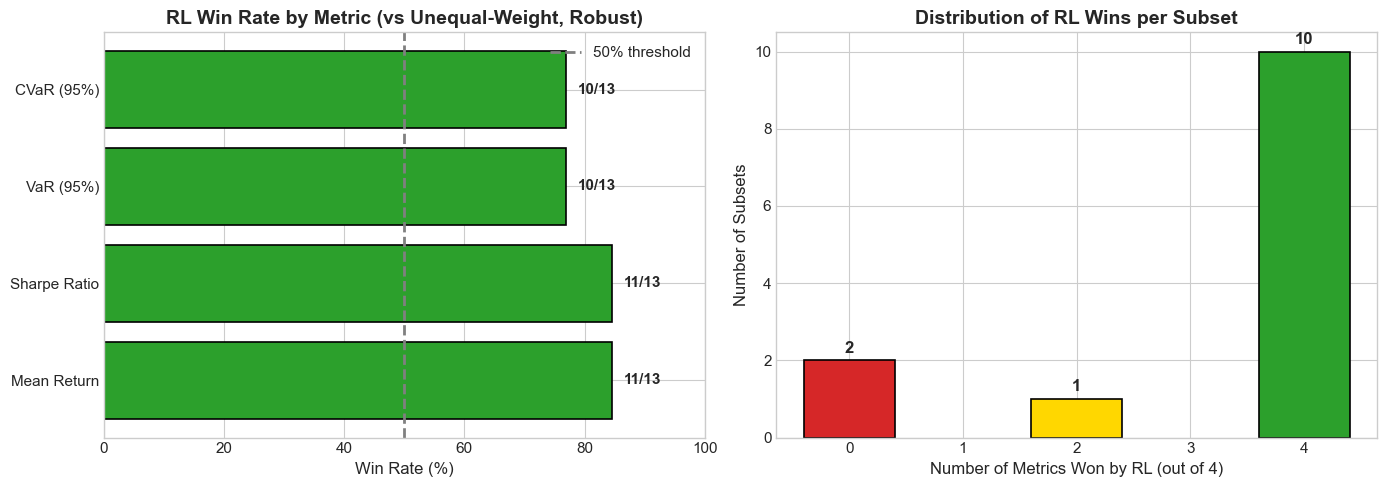

In [12]:
# Win rate by metric - bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Win rate by metric ---
ax1 = axes[0]
metrics = list(win_counts.keys())
wins = list(win_counts.values())
rates = [w/n_subsets*100 for w in wins]

colors = ['C2' if r >= 50 else 'C3' for r in rates]
bars = ax1.barh(metrics, rates, color=colors, edgecolor='black', linewidth=1.2)
ax1.axvline(50, color='gray', linestyle='--', linewidth=2, label='50% threshold')
ax1.set_xlabel('Win Rate (%)', fontsize=12)
ax1.set_title('RL Win Rate by Metric (vs Unequal-Weight, Robust)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 100)

for bar, rate, w in zip(bars, rates, wins):
    ax1.text(rate + 2, bar.get_y() + bar.get_height()/2, f'{w}/{n_subsets}', 
             va='center', fontsize=11, fontweight='bold')

ax1.legend()

# --- Right: Distribution of total wins ---
ax2 = axes[1]
win_dist = valid_results["total_wins"].value_counts().sort_index()
colors2 = ['C3', 'C3', 'gold', 'C2', 'C2']
ax2.bar(win_dist.index, win_dist.values, color=[colors2[i] for i in win_dist.index], 
        edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Number of Metrics Won by RL (out of 4)', fontsize=12)
ax2.set_ylabel('Number of Subsets', fontsize=12)
ax2.set_title('Distribution of RL Wins per Subset', fontsize=14, fontweight='bold')
ax2.set_xticks([0, 1, 2, 3, 4])

for i, v in zip(win_dist.index, win_dist.values):
    ax2.text(i, v + 0.2, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Detailed Comparison Table

In [13]:
# Create a detailed comparison table with win indicators
detail_df = valid_results[[
    "subset_name", "n_tickers", 
    "current_mean_return", "rl_mean_return", "rl_wins_return",
    "current_sharpe", "rl_sharpe", "rl_wins_sharpe",
    "total_wins"
]].copy()

detail_df["Winner"] = detail_df["total_wins"].apply(
    lambda x: "🏆 RL" if x >= 3 else ("⚖️ Tie" if x == 2 else "📊 Unequal-Wt")
)

def highlight_winner(row):
    if row["total_wins"] >= 3:
        return ['background-color: #2ecc71; color: #0b2e13; font-weight: bold'] * len(row)
    elif row["total_wins"] <= 1:
        return ['background-color: #e74c3c; color: white; font-weight: bold'] * len(row)
    else:
        return ['background-color: #f1c40f; color: #3a2f00; font-weight: bold'] * len(row)

styled_df = detail_df.style.apply(highlight_winner, axis=1).format({
    "current_mean_return": "{:.2%}",
    "rl_mean_return": "{:.2%}",
    "current_sharpe": "{:.3f}",
    "rl_sharpe": "{:.3f}",
})

print("Detailed Results (Green=RL wins 3+, Yellow=Tie, Red=Unequal-weight wins):")
display(styled_df)

Detailed Results (Green=RL wins 3+, Yellow=Tie, Red=Unequal-weight wins):


,subset_name,n_tickers,current_mean_return,rl_mean_return,rl_wins_return,current_sharpe,rl_sharpe,rl_wins_sharpe,total_wins,Winner
0,Banks,5,13.30%,11.94%,False,0.831,0.754,False,0,📊 Unequal-Wt
1,IT,5,1.20%,6.30%,True,0.102,0.446,True,4,🏆 RL
2,Pharma,3,10.71%,11.63%,True,0.796,0.809,True,2,⚖️ Tie
3,Consumer,4,11.27%,14.00%,True,1.035,1.193,True,4,🏆 RL
4,Auto,3,5.70%,5.69%,False,0.311,0.304,False,0,📊 Unequal-Wt
5,Energy_Infra,4,3.05%,4.73%,True,0.198,0.312,True,4,🏆 RL
6,Banks_IT,5,10.95%,16.09%,True,0.795,0.996,True,4,🏆 RL
7,Diversified_6,6,2.64%,4.36%,True,0.221,0.369,True,4,🏆 RL
8,Top_10,10,3.61%,5.18%,True,0.413,0.553,True,4,🏆 RL
9,Small_3,3,0.05%,0.55%,True,0.003,0.033,True,4,🏆 RL


## 12. Return Improvement Analysis

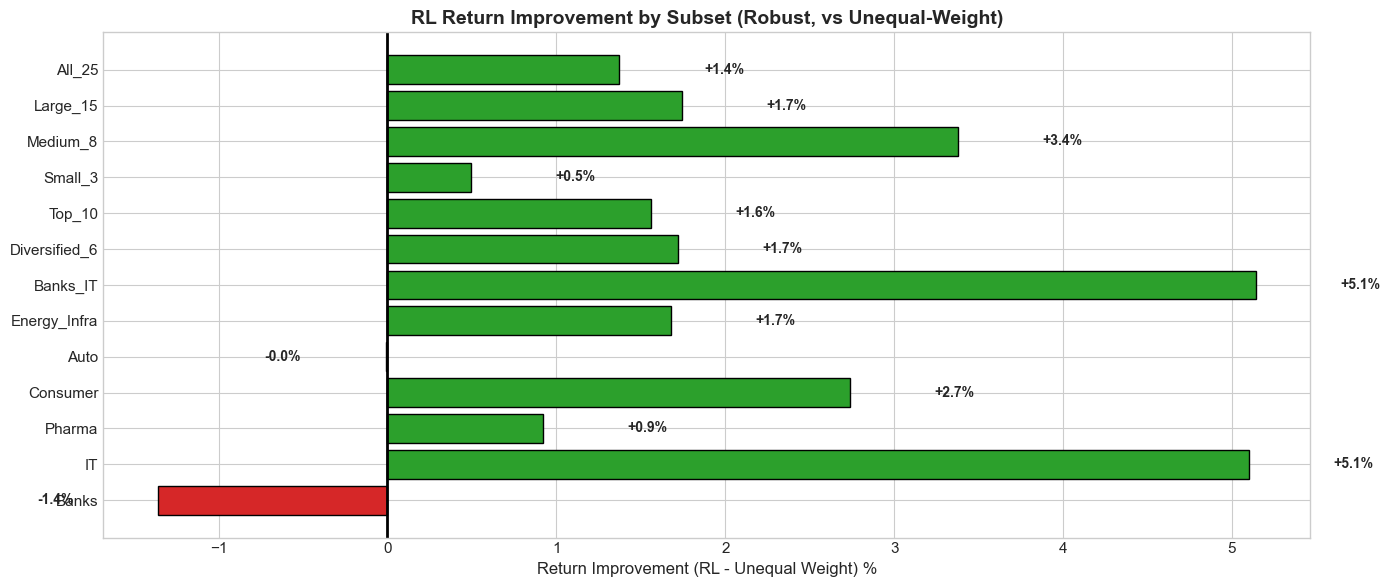


Return Improvement Statistics (vs Unequal-Weight):
  Mean improvement:   +1.88%
  Median improvement: +1.68%
  Max improvement:    +5.14%
  Min improvement:    -1.36%


In [14]:
# Return improvement bar chart
fig, ax = plt.subplots(figsize=(14, 6))

subset_names = valid_results["subset_name"].values
improvements = valid_results["return_improvement"].values * 100

colors = ['C2' if imp >= 0 else 'C3' for imp in improvements]
bars = ax.barh(subset_names, improvements, color=colors, edgecolor='black', linewidth=1)

ax.axvline(0, color='black', linewidth=2)
ax.set_xlabel('Return Improvement (RL - Unequal Weight) %', fontsize=12)
ax.set_title('RL Return Improvement by Subset (Robust, vs Unequal-Weight)', fontsize=14, fontweight='bold')

for bar, imp in zip(bars, improvements):
    x_pos = imp + 0.5 if imp >= 0 else imp - 0.5
    ha = 'left' if imp >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{imp:+.1f}%', 
            va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nReturn Improvement Statistics (vs Unequal-Weight):")
print(f"  Mean improvement:   {valid_results['return_improvement'].mean()*100:+.2f}%")
print(f"  Median improvement: {valid_results['return_improvement'].median()*100:+.2f}%")
print(f"  Max improvement:    {valid_results['return_improvement'].max()*100:+.2f}%")
print(f"  Min improvement:    {valid_results['return_improvement'].min()*100:+.2f}%")

## 13. Sharpe Ratio Comparison

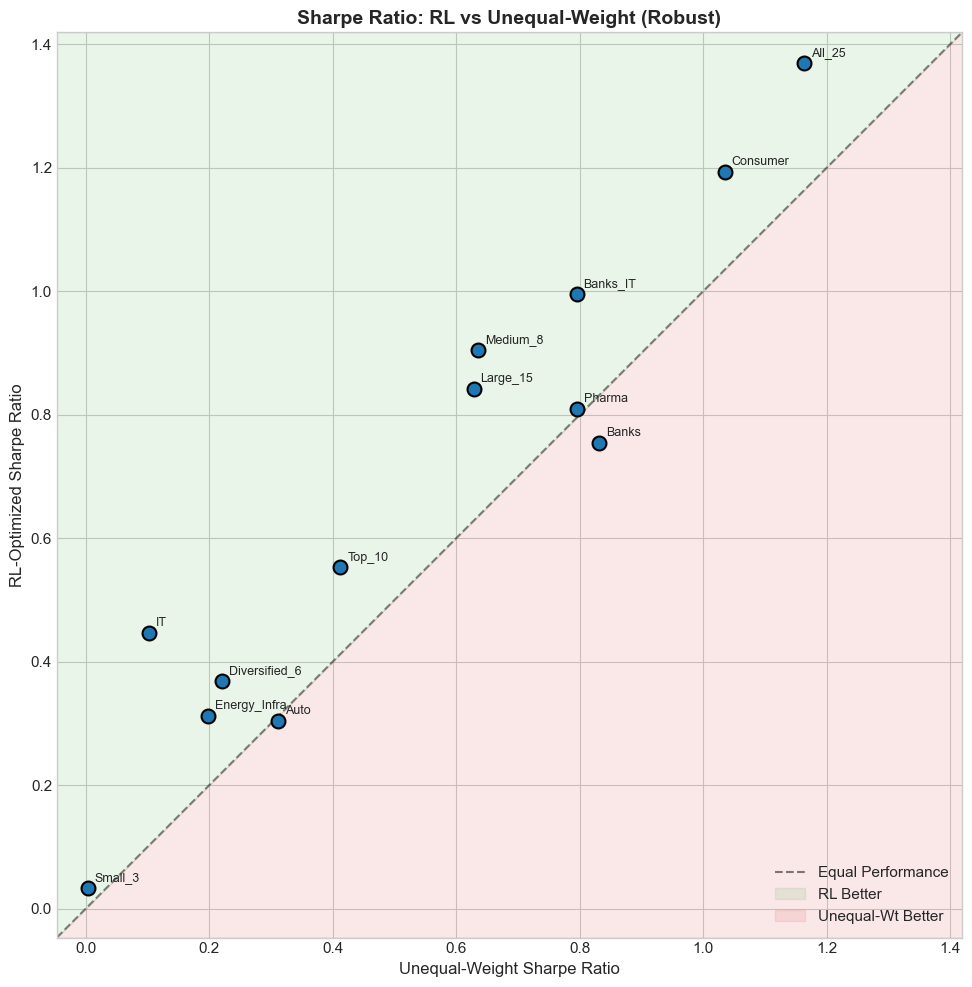

In [15]:
# Sharpe ratio comparison scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

current_sharpe = valid_results["current_sharpe"].values
rl_sharpe = valid_results["rl_sharpe"].values
subset_names = valid_results["subset_name"].values

ax.scatter(current_sharpe, rl_sharpe, s=100, c='C0', edgecolors='black', linewidths=1.5, zorder=5)

for i, name in enumerate(subset_names):
    ax.annotate(name, (current_sharpe[i], rl_sharpe[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

lims = [min(current_sharpe.min(), rl_sharpe.min()) - 0.05,
        max(current_sharpe.max(), rl_sharpe.max()) + 0.05]
ax.plot(lims, lims, 'k--', alpha=0.5, label='Equal Performance', zorder=1)

ax.fill_between(lims, lims, [lims[1], lims[1]], alpha=0.1, color='C2', label='RL Better')
ax.fill_between(lims, [lims[0], lims[0]], lims, alpha=0.1, color='C3', label='Unequal-Wt Better')

ax.set_xlabel('Unequal-Weight Sharpe Ratio', fontsize=12)
ax.set_ylabel('RL-Optimized Sharpe Ratio', fontsize=12)
ax.set_title('Sharpe Ratio: RL vs Unequal-Weight (Robust)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 14. Final Summary

In [16]:
print("=" * 70)
print("     FINAL SUMMARY: RL vs UNEQUAL-WEIGHT (ROBUST INFERENCE)")
print("=" * 70)

print(f"\n📊 SUBSETS TESTED: {n_subsets}")
print(f"   Baseline: Market-cap-inspired UNEQUAL weights")

print(f"\n⚙️  ROBUST CONFIG USED:")
print(f"   • Start-step ensemble: {ROBUST_CONFIG['use_start_ensemble']} (offsets: {ROBUST_CONFIG['start_offsets']})")
print(f"   • Last-K smoothing: K={ROBUST_CONFIG['last_k']}")
print(f"   • Cap/Floor: {ROBUST_CONFIG['cap']*100:.0f}% / {ROBUST_CONFIG['floor']*100:.0f}%")
print(f"   • Softmax temperature: T={ROBUST_CONFIG['temperature']}")
print(f"   • MC paths: {ROBUST_CONFIG['n_paths']}, noise: {ROBUST_CONFIG['noise']}")

print(f"\n🎯 WIN RATES BY METRIC:")
for metric, wins in win_counts.items():
    emoji = "✅" if wins > n_subsets/2 else "❌"
    print(f"   {emoji} {metric}: {wins}/{n_subsets} ({wins/n_subsets:.1%})")

print(f"\n🏆 OVERALL VERDICT:")
total_metric_wins = sum(win_counts.values())
total_metric_tests = n_subsets * 4
overall_win_rate = total_metric_wins / total_metric_tests

print(f"   Total metric wins: {total_metric_wins}/{total_metric_tests} ({overall_win_rate:.1%})")

if overall_win_rate > 0.6:
    verdict = "RL CLEARLY OUTPERFORMS unequal-weight allocation"
    emoji = "🚀"
elif overall_win_rate > 0.5:
    verdict = "RL SLIGHTLY OUTPERFORMS unequal-weight allocation"
    emoji = "📈"
elif overall_win_rate > 0.4:
    verdict = "MIXED RESULTS - neither clearly dominates"
    emoji = "⚖️"
else:
    verdict = "Unequal-weight OUTPERFORMS RL on this data"
    emoji = "📊"

print(f"\n   {emoji} {verdict}")

print(f"\n📈 RETURN IMPROVEMENT (RL - Unequal):")
print(f"   Average: {valid_results['return_improvement'].mean()*100:+.2f}%")
print(f"   Best:    {valid_results['return_improvement'].max()*100:+.2f}% ({valid_results.loc[valid_results['return_improvement'].idxmax(), 'subset_name']})")
print(f"   Worst:   {valid_results['return_improvement'].min()*100:+.2f}% ({valid_results.loc[valid_results['return_improvement'].idxmin(), 'subset_name']})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • RL won ALL 4 metrics in {len(rl_dominates)} subset(s): {list(rl_dominates['subset_name'].values) if len(rl_dominates) > 0 else 'None'}")
print(f"   • RL won 3+ metrics in {len(rl_majority)} subset(s)")
print(f"   • Unequal-weight won 3+ metrics in {len(baseline_majority)} subset(s): {list(baseline_majority['subset_name'].values) if len(baseline_majority) > 0 else 'None'}")

print("\n" + "=" * 70)

     FINAL SUMMARY: RL vs UNEQUAL-WEIGHT (ROBUST INFERENCE)

📊 SUBSETS TESTED: 13
   Baseline: Market-cap-inspired UNEQUAL weights

⚙️  ROBUST CONFIG USED:
   • Start-step ensemble: True (offsets: [-4, -3, -2, -1, 0])
   • Last-K smoothing: K=5
   • Cap/Floor: 15% / 2%
   • Softmax temperature: T=2.0
   • MC paths: 2000, noise: block_bootstrap

🎯 WIN RATES BY METRIC:
   ✅ Mean Return: 11/13 (84.6%)
   ✅ Sharpe Ratio: 11/13 (84.6%)
   ✅ VaR (95%): 10/13 (76.9%)
   ✅ CVaR (95%): 10/13 (76.9%)

🏆 OVERALL VERDICT:
   Total metric wins: 42/52 (80.8%)

   🚀 RL CLEARLY OUTPERFORMS unequal-weight allocation

📈 RETURN IMPROVEMENT (RL - Unequal):
   Average: +1.88%
   Best:    +5.14% (Banks_IT)
   Worst:   -1.36% (Banks)

💡 KEY INSIGHTS:
   • RL won ALL 4 metrics in 10 subset(s): ['IT', 'Consumer', 'Energy_Infra', 'Banks_IT', 'Diversified_6', 'Top_10', 'Small_3', 'Medium_8', 'Large_15', 'All_25']
   • RL won 3+ metrics in 10 subset(s)
   • Unequal-weight won 3+ metrics in 2 subset(s): ['Banks', 

In [17]:
# Save results to CSV
output_path = project_root / "data" / "subset_unequal_robust_test_results.csv"
valid_results.to_csv(output_path, index=False)
print(f"✓ Results saved to {output_path}")

✓ Results saved to c:\Users\Atharva Srivastava\Downloads\anndl\data\subset_unequal_robust_test_results.csv
